# Face Detection with HOG + SVM

##  آماده سازی دیتاست
برای آماده‌سازی دیتای لازم آموزش، تصاویر پایگاه داده $\text{LFW}$ را به عنوان تصاویر مثبت و تصاویر پاک‌سازی شده و بدون صورت از دیتاست $\text{Caltech-256}$ (که می‌توانید نسخه پاک‌سازی شده را از [اینجا](https://mega.nz/folder/c6YD2CxQ#upVP9Ybn2afcbp3r6R7WWA) دانلود کنید) را به عنوان تصاویر منفی در نظر می‌گیریم.

## روش
حال از تمامی تصاویر موجود با استفاده از روش $\text{HOG}$ بردار ویژگی استخراج می‌کنیم که پارامتر‌های بهینه استفاده شده در اینجا، به صورت زیر است:

Cell size = 8×8 px

Block size = 2×2 cells

Window size = 128×128 px

Orientation bins = 9

که در اینجا، $\text{Window size}$ پارامتری است که تصاویر قبل از استخراج بردار ویژگی به آن تبدیل می‌شوند.

پس از استخراج بردار ویژگی هر تصویر، آن را به یک کلسیفایر آنلاین ورودی می‌دهیم. آنلاین بودن کلسیفایر به این دلیل است که حجم داده‌های آموزش ورودی بسیار زیاد است(در حدود ۳۵۰۰۰) و بارگذاری همه آن‌ها در حافظه می‌تواند برای بعضی از پارامتر‌ها ناممکن باشد.

کلسیفایر استفاده شده در اینجا، $\text{SGDClassifier}$ است که در حقیقت پیاده سازی روش‌های خطی کلسیفای با استفاده از $\text{Gradient Descent}$ است. در این روش با استفاده از متریک خطای $\text{hinge}$ با نرم $L_2$، می‌توان رفتار $\text{SVM}$ با کرنل خطی را شبیه‌سازی کرد و به صورت $\text{incremental learning}$ عملیات آموزش را انجام داد.
در نهایت داده‌های ولیدیشن را روی مدل آموزش دیده تست می‌کنیم و دقت را اندازه می‌گیریم و هایپر پارامتر‌ها را بهینه می‌کنیم. بهترین پارامتر‌های به دست آمده به صورت زیر است:

Loss function = Hinge

Penalty metric = L2

Penalty coeff = 0.0001

Learning rate = 1/(a*(t+t_0))

پس از به دست آمدن مدل بهینه، آن را روی داده‌های تست بررسی می‌کنیم و نمودارها و متریک‌های خواسته شده را اندازه‌گیری می‌کنیم.

حال برای تشخیص چهره در عکس‌های داده شده با $\text{sliding window}$ در اسکیل‌های مختلف، هر عکس را در نظر می‌گیریم و یک پنجره به اندازه $\text{window size}$ تعیین شده در قسمت قبل را روی عکس حرکت می‌دهیم. البته از آنجایی که یک صورت به ازای جا به جایی چند پیکسلی همچنان تشخیص مثبت دارد، پس پنجره را با یک $\text{stride}$ بیش از یک، حرکت می‌دهیم و هر کدام را به کلسیفایر می‌دهیم.

در نهایت باید روی صورت ‌های تشخیص داده‌شده، $\text{Non-Maximum Suppression}$ انجام دهیم تا در صورتی که یک صورت چند بار تشخیص داده شده، آن را حذف کنیم و بهترین مربع دربرگیرنده صورت را انتخاب کنیم. بعلاوه، برای سلکتیو تر شدن کلسیفایر(فالس پازتیو ها کمتر شوند)، با توجه به مشخصات داده‌های ترین شده در مدل، یک ترشهولد به صورت خودکار برای $\text{decision function}$ کلسیفایر انتخاب می‌کنیم تا علاوه بر مثبت بودن این تابع، از یک ترشهولدی نیز بیشتر باشد. این ترشهولد را برابر فاصله دو سیگما از میانگین فاصله نقاط مثبت از ابرصفحه جداکننده نقاط صورت‌دار و بدون صورت در نظر می‌گیریم تا نقاط نزدیک به ابرصفحه نیز منفی در نظر گرفته شوند.


In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import feature
from sklearn import utils, linear_model, metrics
from sklearn.model_selection import train_test_split

positive_image_path = './data/hw4/pos'
negative_image_path = './data/hw4/neg'
output_path = './out'


def get_all_files(path, pat='jpg'):
    list_of_files = []
    for (dir_path, dir_names, filenames) in os.walk(path):
        list_of_files += [os.path.join(dir_path, file) for file in filenames
                          if file.split('.')[-1].lower() == pat.lower()]
    return list_of_files


# load data
X_file = []
tmp = utils.shuffle(get_all_files(positive_image_path), random_state=0)
X_file += tmp
X_file += utils.shuffle(get_all_files(negative_image_path), random_state=0)
y = np.zeros(len(X_file), dtype=np.int32)
y[:len(tmp)] = 1

# split data
(X_train_file, X_test_file,
 y_train, y_test) = train_test_split(X_file, y,
                                     stratify=y, test_size=2000, random_state=0, shuffle=True)
(X_train_file, X_valid_file,
 y_train, y_valid) = train_test_split(X_train_file, y_train,
                                      stratify=y_train, test_size=2000, random_state=0, shuffle=True)

In [2]:
def get_image(filename, size=(128, 128), margin=(50, 50, 50, 50), min_size=(150, 150)):
    src = cv.imread(filename)
    if src.shape[0] > min_size[0] and src.shape[1] > min_size[1]:
        src = src[margin[0]:-margin[1], margin[2]:-margin[3], :]
    return cv.resize(src, size, interpolation=cv.INTER_AREA)


def get_descriptor(src, cell_size=(8, 8), block_size=(2, 2), n_bins=9):
    hog = cv.HOGDescriptor(_winSize=(src.shape[1] // cell_size[1] * cell_size[1],
                                     src.shape[0] // cell_size[0] * cell_size[0]),
                           _blockSize=(block_size[1] * cell_size[1],
                                       block_size[0] * cell_size[0]),
                           _blockStride=(cell_size[1], cell_size[0]),
                           _cellSize=(cell_size[1], cell_size[0]),
                           _nbins=n_bins)
    return hog.compute(src).ravel()


# fit a gd linear svm
sgd = linear_model.SGDClassifier(loss='hinge',
                                 penalty='l2',
                                 fit_intercept=True,
                                 alpha=0.0001,
                                 shuffle=False,
                                 learning_rate='optimal')
for i, (filename, label) in enumerate(zip(X_train_file, y_train)):
    ft = get_descriptor(get_image(filename))
    sgd.partial_fit([ft], [label], classes=[0, 1])

In [3]:
# evaluate model
def evaluate_model(clf, X_file, y):
    y_pred = np.zeros_like(y)
    y_score = np.zeros_like(y, dtype=float)
    for i, filename in enumerate(X_file):
        ft = get_descriptor(get_image(filename))
        y_pred[i] = clf.predict([ft])
        y_score[i] = clf.decision_function([ft])
    return y_pred, y_score


def calculate_accuracy(y, y_pred, y_score):
    return metrics.accuracy_score(y, y_pred)


def calculate_roc(y, y_pred, y_score):
    return metrics.roc_curve(y, y_score)


def calculate_roc_auc(y, y_pred, y_score):
    return metrics.roc_auc_score(y, y_score)


def calculate_ap(y, y_pred, y_score):
    return metrics.average_precision_score(y, y_score)


def calculate_prc(y, y_pred, y_score):
    return metrics.precision_recall_curve(y, y_score)

In [4]:
# evaluate validation data and tune parameters
eval_valid = evaluate_model(sgd, X_valid_file, y_valid)
print(f'validation accuracy = {calculate_accuracy(y_valid, *eval_valid)}')

validation accuracy = 0.995


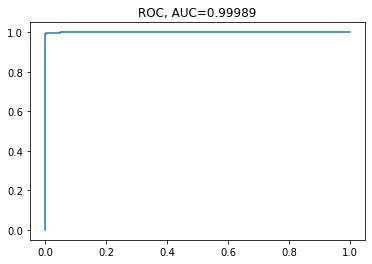

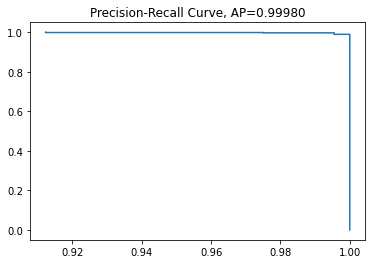

Average precision on test data = 0.99980


In [5]:
eval_test = evaluate_model(sgd, X_test_file, y_test)
score_test = calculate_accuracy(y_test, *eval_test)
roc_test = calculate_roc(y_test, *eval_test)
roc_auc_test = calculate_roc_auc(y_test, *eval_test)
prc_test = calculate_prc(y_test, *eval_test)
ap_test = calculate_ap(y_test, *eval_test)

plt.plot(roc_test[0], roc_test[1])
plt.title(f'ROC, AUC={roc_auc_test:.5f}')
plt.show()

plt.plot(prc_test[0], prc_test[1])
plt.title(f'Precision-Recall Curve, AP={ap_test:.5f}')
plt.show()

print(f'Average precision on test data = {ap_test:.5f}')

In [6]:
def FaceDetection(clf, img, window_size=(128, 128),
                  stride=15, scale_step=0.1, scale_range=(0.5, 2), padding=0.2, threshold=30):
    frame = np.zeros((int(img.shape[0] * (1 + padding)), int(img.shape[1] * (1 + padding)), 3), dtype=np.uint8)
    frame[int(img.shape[0] * padding / 2):int(img.shape[0] * padding / 2) + img.shape[0],
    int(img.shape[1] * padding / 2):int(img.shape[1] * padding / 2) + img.shape[1], :] = img

    frame_res = frame.copy()
    frame_scores = np.zeros(frame_res.shape[:2])
    frame_pos = np.zeros(frame_res.shape[:2] + (2,), dtype=int)

    for scale in np.arange(scale_range[0], scale_range[1], scale_step):
        img = cv.resize(frame, (0, 0), None, scale, scale, cv.INTER_AREA)
        for i in np.arange(0, img.shape[0] - window_size[0], stride):
            for j in np.arange(0, img.shape[1] - window_size[1], stride):
                patch = img[i:i + window_size[0], j:j + window_size[1], :]
                score = clf.decision_function([get_descriptor(patch)])[0]
                if score > threshold:
                    pt1 = np.array([i, j]) / scale
                    pt2 = np.array([i + window_size[0], j + window_size[1]]) / scale
                    if frame_scores[tuple(pt1.astype(int))] < score:
                        frame_scores[tuple(pt1.astype(int))] = score
                        frame_pos[tuple(pt1.astype(int))] = tuple(pt2.astype(int))
    peaks = feature.peak_local_max(frame_scores, 3 * stride)
    for peak in peaks:
        cv.rectangle(frame_res, tuple(peak)[::-1], tuple(frame_pos[tuple(peak)][::-1]), (255, 0, 0), 5)
    return frame_res

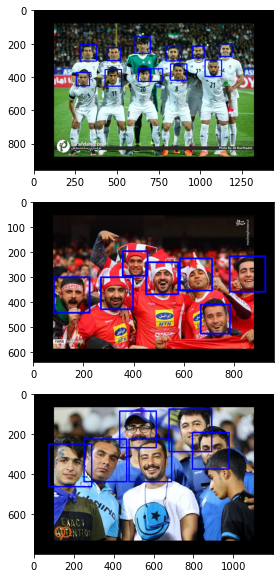

In [9]:
img1 = cv.imread('./data/hw4/Melli.jpg')
img2 = cv.imread('./data/hw4/Persepolis.jpg')
img3 = cv.imread('./data/hw4/Esteghlal.jpg')

sgd_threshold = eval_valid[1][eval_valid[1] > 0].mean() - 2 * eval_valid[1][eval_valid[1] > 0].std()

img1_det = FaceDetection(sgd, img1, scale_range=(1, 2), threshold=sgd_threshold)
img2_det = FaceDetection(sgd, img2, scale_range=(0.5, 1.5), threshold=sgd_threshold)
img3_det = FaceDetection(sgd, img3, scale_range=(0.5, 1.5), threshold=sgd_threshold)

plt.figure(figsize=(30,10))
plt.subplot(311)
plt.imshow(img1_det[:, :, ::-1])
plt.subplot(312)
plt.imshow(img2_det[:, :, ::-1])
plt.subplot(313)
plt.imshow(img3_det[:, :, ::-1])
plt.show()
